In [14]:
import sys
sys.path.append('/SEE-MTDA/see')
from sc.mesher.mesher import Mesher
import numpy as np
import os
import glob
from pathlib import Path
from sc.datasets.shared_utils import *
import open3d as o3d
from easydict import EasyDict
import yaml
from PIL import Image

from sc.mesher.mesher_methods import db_scan

def cfg_from_yaml_file(cfg_file):
    cfg = EasyDict()
    print("\n----- Cfgs -----")
    with open(cfg_file, 'r') as f:
        yaml_config = yaml.safe_load(f)
        print(yaml.dump(yaml_config))

    cfg.update(EasyDict(yaml_config))

    return cfg

def get_conf(preds, labels, class_inds):
    # Get confusion matrix
    # Implementation from https://github.com/yanx27/JS3C-Net/blob/c4eed02b2febc118b31c074a9f1d6321ad1c04be/utils/np_ioueval.py#L56        
    
    nclasses = len(class_inds)
    conf = np.zeros((nclasses, nclasses))
    idxs = tuple(np.stack((preds, labels), axis=0))
    np.add.at(conf, idxs, 1)
    return conf
    
def getIOU(preds, labels, class_inds):
    
    # Confusion matrix
    conf = get_conf(preds, labels, class_inds)
    
    # Calculate IOU
    tp = np.diag(conf)
    fp = conf.sum(axis=1)-tp
    fn = conf.sum(axis=0)-tp
    intersection = tp
    union = tp + fp + fn + 1e-15
    iou = intersection/ union 

    # If there are no labels for the class in that sample, assign 100%.
    # So we don't mess up the mean calculation
    class_inds = set(class_inds)
    absent_classes = list(class_inds - (class_inds & set(labels[:,0])))
    iou[absent_classes] = np.nan
    
    return iou, np.nanmean(iou)

def getPR(preds, labels, class_inds):
    # Confusion matrix
    conf = get_conf(preds, labels, class_inds)
    
    # Calculate IOU
    tp = np.diag(conf)
    fp = conf.sum(axis=1)-tp
    fn = conf.sum(axis=0)-tp
    
    precision = tp/(tp + fp  + 1e-15)
    recall = tp/(tp + fn  + 1e-15)
    return precision, recall

cfg_file = '/SEE-MTDA/see/sc/cfgs/KIT-DM-ORH005.yaml'
cfg = cfg_from_yaml_file(cfg_file)
mesher = Mesher(cfg=cfg, cfg_path=cfg_file)


----- Cfgs -----
DATASET:
  CAMERA_CHANNELS:
  - image_2
  CLASSES:
  - Car
  DET2D_MASK: true
  DET2D_MODEL: htc
  NAME: kitti
  POINT_CLOUD_RANGE:
  - -70
  - -70
  - -2
  - 70
  - 70
  - 4
  SHRINK_MASK_PERCENTAGE: 2
DATA_PATH: /SEE-MTDA/data/kitti
MESHER:
  CLUSTERING:
    EPS_SCALING: 5
    NAME: db_scan
  MESH_ALGORITHM:
    LOWER_RADIUS: 0.01
    NAME: ball_pivoting
    UPPER_RADIUS: 1.155
  MIN_LIDAR_PTS_TO_MESH: 30
  NAME: det_mesh
  REPLACE_OBJECT_WITH_MESH:
    POINT_DISTANCE_THRESH: 0.1
  SAMPLING:
    NAME: vres_ring_based_sampling
    OPTIMAL_RING_HEIGHT: 0.05
    TYPE: poisson
  VRES: 0.4

Loading masks...
loading annotations into memory...
Done (t=1.36s)
creating index...
index created!
KittiObjects initialised!

Mesher Initialised!


In [15]:
class SemKITTI_inst():
    def __init__(self, data_path, label_mapping="semantic-kitti.yaml", imageset='train'):
        
        self.imageset = imageset
        with open(label_mapping, 'r') as stream:
            semkittiyaml = yaml.safe_load(stream)
        self.semkittiyaml = semkittiyaml

        # 70% train, 15% val, 15% test
        num_samples = len(glob.glob(str((Path(data_path) / "pointcloud" /"*").absolute())))
        print(f'Found {num_samples} in {str((Path(data_path) / "pointcloud" /"*").absolute())}')
        train_idx = [i for i in range(int(0.7*num_samples))]
        val_idx = [i for i in range(max(train_idx)+1,max(train_idx)+1 + int(0.15*num_samples))]
        test_idx = [i for i in range(max(val_idx)+1, num_samples-1)]

        if imageset == 'train':
            split = train_idx
        elif imageset == 'val':
            split = val_idx
        elif imageset == 'test':
            split = test_idx
        elif imageset == 'mini':
            # Mini uses only a tiny subset to check if we can overfit on a small sample dataset for prototyping
            split = [i for i in range(num_samples-int(0.05*num_samples), num_samples-1)]
        elif imageset == 'all':
            # Use entire dataset e.g. for evaluating on Baraja where I don't train on it
            split = [i for i in range(num_samples)]
            
        else:
            raise Exception('Split must be train/val/test/mini/all')

        print(f'Preparing {len(split)} samples for {imageset}')
        self.im_idx = []
        for lidar_idx in split:
            self.im_idx.append(str((Path(data_path) / "pointcloud"  / f"{lidar_idx:06}.bin").absolute()))

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.im_idx)

    def __getitem__(self, index):
        raw_data = np.fromfile(self.im_idx[index], dtype=np.float32).reshape((-1, 4))        
        if self.imageset == 'test':
            annotated_data = np.expand_dims(np.zeros_like(raw_data[:, 0], dtype=int), axis=1)
        else:            
            annotated_data = np.fromfile(self.im_idx[index].replace('pointcloud', 'labels')[:-3] + 'label',
                                         dtype=np.uint32).reshape((-1, 1))
            annotated_data = annotated_data & 0xFFFF  # delete high 16 digits binary
            annotated_data = np.vectorize(self.semkittiyaml['learning_map'].__getitem__)(annotated_data)

        data_tuple = (raw_data[:, :3], annotated_data.astype(np.uint8), self.im_idx[index])

        return data_tuple

# Single Evaluation

In [3]:
# Define mask path (this is the one we use, not the yaml)
data_dir='/SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_mask'
Path(data_dir).exists()

pc_dataset = SemKITTI_inst(data_dir, imageset='val')

Found 33631 in /SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_mask/pointcloud/*
Preparing 5044 samples for val


Getting results for /SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_mask/pointcloud/023557.bin


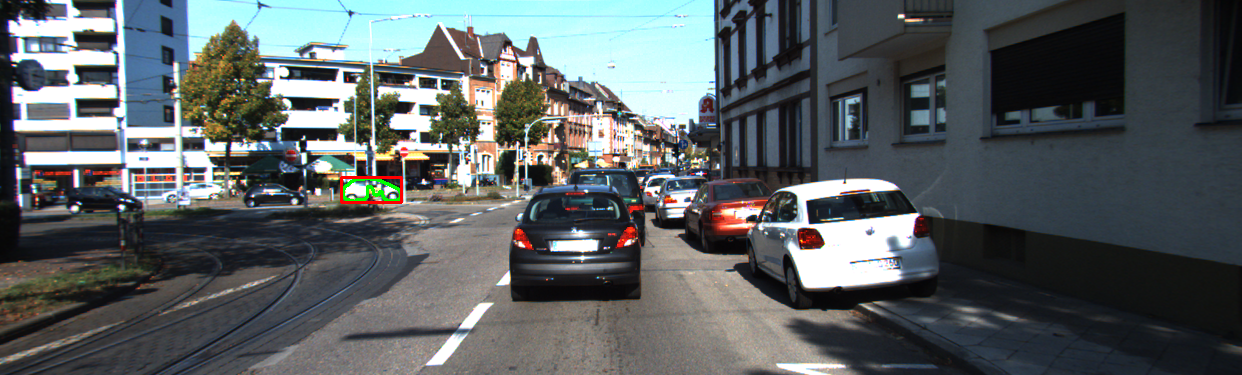

eps=0.98309


In [74]:
# Load data
sample_idx = 16
pts, gt_label, filepath = pc_dataset.__getitem__(sample_idx)
print(f'Getting results for {filepath}')
 
img = Image.open(filepath.replace('pointcloud', 'image').replace('.bin', '.png'))
img.show()

# Cluster and label largest cluster as car
pcd = convert_to_o3dpcd(pts)
centroid_dist = np.linalg.norm(np.asarray(pcd.get_center()))
initial_ring_height = centroid_dist * np.tan(mesher.mesher_cfg.VRES * np.pi/180)
dbpcd = pcd
eps = mesher.mesher_cfg.CLUSTERING.EPS_SCALING * initial_ring_height
print(f'eps={eps:0.5f}')
labels = np.array(dbpcd.cluster_dbscan(eps=eps, min_points=3, print_progress=False))
y = np.bincount(labels[labels >= 0])
if len(y) != 0:
    value = np.argmax(y)
    most_points = np.argwhere(labels == value)
    
    # Label the largest cluster as "car" (i.e. idx: 1) and the rest "stuff" (idx: 0)
    pred_label = np.zeros((pts.shape[0],1), dtype=np.int64)
    pred_label[most_points] = 1

In [72]:
class_iou, _ = getIOU(pred_label, gt_label, [0,1]) 
precision, recall = getPR(pred_label, gt_label, [0,1]) 
print(f'mIOU: stuff={class_iou[0]:0.6f}, car={class_iou[1]:0.6f}')
print(f'precision (penalize pts outside box): car={precision[1]:0.6f}')
print(f'recall (num correct/all): car={recall[1]:0.6f}')

# Precision tp/(tp+fp): Penalizes obj points outside of box
# Recall tp/(tp+fn): How many obj points correctly predicted over all obj points

conf = get_conf(pred_label, gt_label, [0,1]) 

# Calculate IOU
tp = np.diag(conf)
fp = conf.sum(axis=1)-tp
fn = conf.sum(axis=0)-tp
# print(tp, fp, fn)
# print(conf)

mIOU: stuff=0.500000, car=0.527778
precision (penalize pts outside box): car=0.791667
recall (num correct/all): car=0.612903


In [73]:
bbox_raw = np.loadtxt(filepath.replace('pointcloud', 'gt_bboxes').replace('.bin', '.txt'))
if np.count_nonzero(bbox_raw) != 0:
    boxpts = o3d.utility.Vector3dVector(bbox_raw)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    
label_to_color = pred_label
# label_to_color = gtlabel

colors = np.array([np.array(list(reversed(pc_dataset.semkittiyaml['color_map'][cls])))/255 for cls in label_to_color[:,0]])
pcd.colors = o3d.utility.Vector3dVector(colors)

if np.count_nonzero(bbox_raw) != 0:
    o3d.visualization.draw_geometries([pcd, o3dbox])
else:
    o3d.visualization.draw_geometries([pcd])

# Evaluation over validation dataset

In [8]:
# Define mask path (this is the one we use, not the yaml)
data_dir='/SEE-MTDA/data/nuscenes/custom_t4025-v3980/exported/lidar_seg_data/points_in_bbox/CAM_FRONT'
Path(data_dir).exists()

pc_dataset = SemKITTI_inst(data_dir, imageset='val')

Found 21471 in /SEE-MTDA/data/nuscenes/custom_t4025-v3980/exported/lidar_seg_data/points_in_bbox/CAM_FRONT/pointcloud/*
Preparing 3220 samples for val


In [19]:
from tqdm import tqdm
import time

running_iou, running_precision, running_recall = [],[],[]
num_pts, runtime = [],[]

for sample_idx in tqdm(range(len(pc_dataset)), desc='Eval'):
    
    t0 = time.time()
    pts, gt_label, filepath = pc_dataset.__getitem__(sample_idx)
    
    # Cluster and label largest cluster as car
    pcd = convert_to_o3dpcd(pts)
    centroid_dist = np.linalg.norm(np.asarray(pcd.get_center()))
    initial_ring_height = centroid_dist * np.tan(mesher.mesher_cfg.VRES * np.pi/180)
    dbpcd = pcd
    eps = mesher.mesher_cfg.CLUSTERING.EPS_SCALING * initial_ring_height
    labels = np.array(dbpcd.cluster_dbscan(eps=eps, min_points=3, print_progress=False))
    y = np.bincount(labels[labels >= 0])
    pred_label = np.zeros((pts.shape[0],1), dtype=np.int64)
    if len(y) != 0:
        value = np.argmax(y)
        most_points = np.argwhere(labels == value)

        # Label the largest cluster as "car" (i.e. idx: 1) and the rest "stuff" (idx: 0)        
        pred_label[most_points] = 1
    
    runtime.append(time.time()-t0)
    num_pts.append(len(pts))
    
    class_iou, _ = getIOU(pred_label, gt_label, [0,1]) 
    precision, recall = getPR(pred_label, gt_label, [0,1]) 
    running_iou.append(class_iou)
    running_precision.append(precision)
    running_recall.append(recall)
    
    
mean_precision = np.nanmean(running_precision,axis=0)
mean_recall = np.nanmean(running_recall,axis=0)
mean_classiou = np.nanmean(running_iou,axis=0)
print(f'\nmIOU: car={mean_classiou[1]:0.6f}, stuff={mean_classiou[0]:0.6f}')
print(f'Mean Precision: car={mean_precision[1]:0.6f}')
print(f'Mean Recall: car={mean_recall[1]:0.6f}')

Eval: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3220/3220 [00:02<00:00, 1105.93it/s]


mIOU: car=0.634149, stuff=0.565249
Mean Precision: car=0.544531
Mean Recall: car=0.578035


Text(0.5, 1.0, 'DBScan for KITTI')

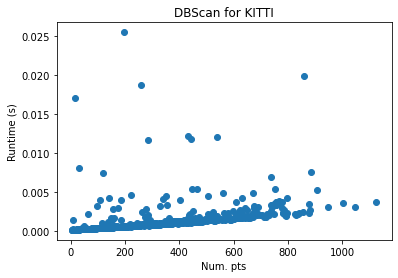

In [21]:
import matplotlib.pyplot as plt

speed = sorted(zip(runtime, num_pts), key=lambda x:x[1])
sorted_pts, sorted_runtime = [],[]
for s in speed:
    if s[1] in sorted_pts:
        continue
    else:
        sorted_pts.append(s[1])
        sorted_runtime.append(s[0])

plt.scatter(sorted_pts, sorted_runtime)
plt.xlabel('Num. pts')
plt.ylabel('Runtime (s)')
plt.title('DBScan for KITTI')